In [48]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Lab 3 (Preprocessing)

## Loading data

In [49]:
X = pd.read_csv('train.csv',
                 index_col=0,
                 na_values='NA',
                 keep_default_na=False)
X_train = X.drop(["SalePrice"], axis=1)
y_train = X["SalePrice"]
X_test = pd.read_csv('test.csv',
                   index_col=0,
                   na_values='NA',
                   keep_default_na=False)

## Transformations

### Splitting Data

In [50]:
categorical_features = X_train.select_dtypes(object)
categorical_index = categorical_features.columns
numerical_features = X_train.select_dtypes(np.number)
numerical_index = numerical_features.columns

### Numerical Imputing

In [51]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')

# Train
X_train_num = X_train.drop(categorical_index, axis=1)
imputer.fit(X_train_num)
X_train_num = pd.DataFrame(imputer.transform(X_train_num).astype(np.float32), columns=numerical_index)

# Test
X_test_num = X_test.drop(categorical_index, axis=1)
X_test_num = pd.DataFrame(imputer.transform(X_test_num).astype(np.float32), columns=numerical_index)

### Categorical Encoding

In [52]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_cat = X_train.drop(numerical_index, axis=1)
X_test_cat = X_test.drop(numerical_index, axis=1)

# Train
ohe.fit(X_train_cat)
X_train_ohe = ohe.transform(X_train_cat).astype(bool)
X_train_ohe = pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names_out(X_train_cat.columns.tolist()))

# Test
X_test_ohe = ohe.transform(X_test_cat).astype(bool)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=ohe.get_feature_names_out(X_test_cat.columns.tolist()))

## Feature Engineering

In [53]:
# Creating new feature
X_train_num["Avg_RoomSF"] = (X_train_num["1stFlrSF"] + X_train_num["2ndFlrSF"]) / X_train_num["TotRmsAbvGrd"]
X_test_num["Avg_RoomSF"] = (X_test_num["1stFlrSF"] + X_test_num["2ndFlrSF"]) / X_test_num["TotRmsAbvGrd"]

In [54]:
# Merging numerical and categorical features
X_train_cleaned = pd.concat([X_train_num, X_train_ohe], axis=1)
X_test_cleaned = pd.concat([X_test_num, X_test_ohe], axis=1)

## Refactor

In [61]:
def preprocess(X_train, X_test=None):
    """
    Preprocesses a set of train and test feature matrices by applying the following transformations:
    - Imputes missing numerical values with the median value of the feature
    - Encodes categorical features through one hot encoding
    - Creates a new feature, Avg_RoomSF (average room area in square feet)
    
    Arguments:
        X_train (DataFrame): Input feature matrix of training data.
        X_test (DataFrame): Input feature matrix of test data. This argument is optional.
    
    Returns:
        X_train_cleaned (DataFrame): Transformed feature matrix of training data.
        X_test_cleaned (DataFrame): Transformed feature matrix of test data.
    
    Notes:
        Target feature ("SalePrice") is not expected in X_train or X_test.
        The features "1stFlrSF", "2ndFlrSF", and "TotRmsAbvGrd" are expected in X_train and X_test.
    """
    
    # Initialising
    categorical_features = X_train.select_dtypes(include=object)
    categorical_index = categorical_features.columns
    numerical_features = X_train.select_dtypes(exclude=object)
    numerical_index = numerical_features.columns
    
    imputer = SimpleImputer(strategy='median')
    
    # Numerical imputing
    X_train_num = X_train.drop(categorical_index, axis=1)
    imputer.fit(X_train_num)
    X_train_num = pd.DataFrame(imputer.transform(X_train_num).astype(np.float32), columns=numerical_index)
    
    # Categorical encoding
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    X_train_cat = X_train.drop(numerical_index, axis=1)
    ohe.fit(X_train_cat)
    X_train_ohe = ohe.transform(X_train_cat).astype(bool)
    X_train_ohe = pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names_out(X_train_cat.columns.tolist()))

    # Creating new feature
    X_train_num["Avg_RoomSF"] = (X_train_num["1stFlrSF"] + X_train_num["2ndFlrSF"]) / X_train_num["TotRmsAbvGrd"]
    
    # Merging features
    X_train_cleaned = pd.concat([X_train_num, X_train_ohe], axis=1)
    
    # Applying transformations to test if required
    if X_test is not None:
        X_test_num = X_test.drop(categorical_index, axis=1)
        X_test_num = pd.DataFrame(imputer.transform(X_test_num).astype(np.float32), columns=numerical_index)
        X_test_cat = X_test.drop(numerical_index, axis=1)
        X_test_ohe = ohe.transform(X_test_cat).astype(bool)
        X_test_ohe = pd.DataFrame(X_test_ohe, columns=ohe.get_feature_names_out(X_test_cat.columns.tolist()))
        X_test_num["Avg_RoomSF"] = (X_test_num["1stFlrSF"] + X_test_num["2ndFlrSF"]) / X_test_num["TotRmsAbvGrd"]
        X_test_cleaned = pd.concat([X_test_num, X_test_ohe], axis=1)
        return X_train_cleaned, X_test_cleaned
        
    return X_train_cleaned

# Lab 4 (Model Selection)

In [64]:
from sklearn import linear_model
from sklearn import ensemble
from sklearn import svm
from sklearn import neighbors
from sklearn import tree
from sklearn import dummy

models = [linear_model.LinearRegression, 
          linear_model.ElasticNet,
          ensemble.RandomForestRegressor, 
          svm.SVR,
          neighbors.KNeighborsRegressor,
          tree.DecisionTreeRegressor]

models_keys = ['Linear',
               'Net',
               'Forest',
               'SVR',
               'Neighbors',
               'Tree']

X = pd.read_csv('train.csv',
                 index_col=0,
                 na_values='NA',
                 keep_default_na=False)
X_train = X.drop(["SalePrice"], axis=1)
y_train = X["SalePrice"]
X_test = pd.read_csv('test.csv',
                   index_col=0,
                   na_values='NA',
                   keep_default_na=False)
X_train_cleaned, X_test_cleaned = preprocess(X_train, X_test)

## In-sample Performance

In [65]:
from sklearn.metrics import mean_squared_error
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

rmse = lambda t, p: np.sqrt(mean_squared_error(t, p))

in_sample = []
for m in models:
    model = m()
    model.fit(X_train_cleaned, y_train)
    in_sample.append(rmse(y_train, model.predict(X_train_cleaned))) 
pd.Series(dict(zip(models_keys, in_sample)), name="In-sample RMSE")

Linear       23394.540041
Net          32579.520722
Forest       11332.306205
SVR          81394.381766
Neighbors    36785.995277
Tree             0.000000
Name: In-sample RMSE, dtype: float64

## Out-of-sample Performance

In [66]:
from sklearn.model_selection import cross_val_score
out_sample = []

for m in models:
    model = m()
    score = cross_val_score(model, X_train_cleaned, y_train, scoring="neg_mean_squared_error", cv=10)
    rmse_score = np.sqrt(-score)
    out_sample.append(rmse_score.mean()) 
cv_results = pd.Series(dict(zip(models_keys, out_sample)), name="Cross-validation RMSE")
cv_results

Linear       44316.777205
Net          33265.699034
Forest       29366.940304
SVR          80882.090654
Neighbors    45692.117520
Tree         38154.404039
Name: Cross-validation RMSE, dtype: float64

In [67]:
cv_results = cv_results.sort_values(ascending=True)
print("When sorted by RMSE, the top three most promising models resulting from cross-validation are:")
for i in range(3):
    print(f"{cv_results.index[i]}: {cv_results.iloc[i]}")

When sorted by RMSE, the top three most promising models resulting from cross-validation are:
Forest: 29366.94030408405
Net: 33265.69903438103
Tree: 38154.40403943229


The out-of-sample RMSEs are used to rank performance instead of the in-sample RMSEs, as they are a better indicator of how the model will predict on new, unseen data, such as the test set.

# Lab 6 (Hyperparameter Optimisation)

## Forest

In [71]:
from sklearn.model_selection import GridSearchCV

param_grid = [{"n_estimators": [50, 100, 150], "max_features": ["sqrt", "log2", None]}]
forest_reg = ensemble.RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search.fit(X_train_cleaned, y_train)
best_forest_reg = grid_search.best_estimator_
print(grid_search.best_params_, grid_search.best_score_)
print(f"RMSE = {rmse(y_train, best_forest_reg.predict(X_train_cleaned))}")

{'max_features': None, 'n_estimators': 100} -857108871.8308527
RMSE = 11545.382891520521


## Net

In [43]:
param_grid = [{"alpha": np.logspace(-3, 3, 7), "l1_ratio": np.linspace(0, 1, 5)}]
net_reg = linear_model.ElasticNet()
grid_search = GridSearchCV(net_reg, param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search.fit(X_train_cleaned, y_train)
best_net_reg = grid_search.best_estimator_
print(grid_search.best_params_, grid_search.best_score_)
print(f"RMSE = {rmse(y_train, best_net_reg.predict(X_train_cleaned))}")

{'alpha': 100.0, 'l1_ratio': 1.0} -1021501524.2430137
RMSE = 22958.412779991715


## Tree

In [64]:
param_grid = [{"splitter": ["best", "random"], "max_features": ["sqrt", "log2", None]}]
tree_reg = tree.DecisionTreeRegressor()
grid_search = GridSearchCV(tree_reg, param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search.fit(X_train_cleaned, y_train)
best_tree_reg = grid_search.best_estimator_
print(grid_search.best_params_, grid_search.best_score_)
print(f"RMSE = {rmse(y_train, best_tree_reg.predict(X_train_cleaned))}")

{'max_features': None, 'splitter': 'best'} -1783720429.5301368
RMSE = 0.0


Through optimising model hyperparameters, DecisionTreeRegressor has an RMSE of 0, which is a clear indicator of overfitting.
Therefore, the next-best model, RandomForestRegressor, was chosen as the best performing learning algorithm with the following hyperparameters:

n_estimators = 100, max_features = None

## Kaggle Submission

In [74]:
kaggle_model = ensemble.RandomForestRegressor(n_estimators=100, max_features=None)
kaggle_model.fit(X_train_cleaned, y_train)
y_pred = pd.Series(kaggle_model.predict(X_test_cleaned), name="SalePrice", index=X_test.index)
y_pred.to_csv("kaggle_submission.csv", header=True)

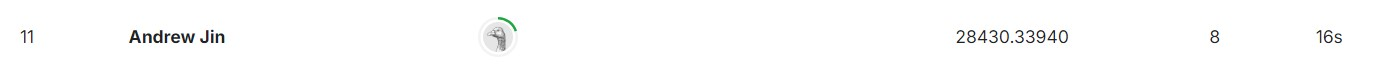

In [63]:
from IPython.display import Image
Image(filename="./leaderboard.jpg")